In [1]:
import os,sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import re
import glob

### Checking for knockdown distribution of guides for each target gene

In [2]:
def cummulative_fraction_pt(df, exp):
    # Remove unnamed column
    df = df.loc[:, ~df.columns.str.startswith("Unnamed")]
    #get target gene name
    df['target_gene'] = df[f'{exp}_guide'].str.split('_').str[0]
    # sort the rows by target gene name
    df = (df.sort_values(['target_gene', f'{exp}_guide'], kind='mergesort')
        .reset_index(drop = True))
    # significant is fdr for a guide is less than 0.1
    df['signif_knockdown'] = df[f'{exp}_fdr'] < 0.1
    # count the number of significant guides for each target gene there mean basal and gene expression
    pl_df = df.groupby('target_gene').agg({
        f'{exp}_basal_exp': 'mean',
        f'{exp}_gene_exp' : 'mean',
        'signif_knockdown': 'sum'
    })
    return pl_df

In [3]:
def plt_cummalative_pt(pl_df, exp, ax=None, show=True, cmap_name="tab20"):
    # the list of unique knockdowns to assign colors
    kds = sorted(pl_df["signif_knockdown"].dropna().astype(int).unique())
    n = len(kds)

    cmap = plt.get_cmap(cmap_name, n) 
    color_map = {kd: cmap(i) for i, kd in enumerate(kds)} 
    
    fig, ax = plt.subplots(figsize=(7, 5), dpi=150) 
    title = f"{exp}"
    for knockdown in kds:
        subset = pl_df[pl_df['signif_knockdown'] == knockdown]
        x = np.sort(subset[f'{exp}_basal_exp'].to_numpy())
        y = np.arange(1, len(x) + 1) / len(x)
    
        ax.plot(
            x, y,
            label=f'{knockdown}/{pl_df["signif_knockdown"].max()} guides (n={len(subset)})',
            linewidth=3,
            color=color_map.ge 
        )
    # set these once
    ax.set_xlabel('Mean target expression in NT controls', fontsize=12)
    ax.set_ylabel('Cumulative fraction of\nperturbed genes', fontsize=12)
    ax.legend(title='Number of effective guides', fontsize=10, title_fontsize=14, ncol =2)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_title(title, fontsize=18)
    
    if show:
        plt.show()
    fig.savefig(os.path.join(plot_pth, f'{exp}_guide_ko_efficiency.png'))
    return fig, ax

### Checking for guide distribution for all the constructs , donors and condition

In [4]:
plot_pth = '/Users/chandrima.modak/Gladstone Dropbox/Chandrima Modak/gw-CRISPRa_from_cluster/plots/'
os.makedirs(plot_pth, exist_ok= True)

/var/folders/lh/8shkr2ln1lz628fhh9nfhqh00000gp/T/ipykernel_95454/1478241527.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Number of effective guides', fontsize=10, title_fontsize=14, ncol =2)


ValueError: {0: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), 1: (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0), 2: (1.0, 0.7333333333333333, 0.47058823529411764, 1.0), 3: (0.596078431372549, 0.8745098039215686, 0.5411764705882353, 1.0), 4: (1.0, 0.596078431372549, 0.5882352941176471, 1.0), 5: (0.7725490196078432, 0.6901960784313725, 0.8352941176470589, 1.0), 6: (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0), 7: (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0), 8: (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0), 9: (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0), 10: (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0), 11: (0.6196078431372549, 0.8549019607843137, 0.8980392156862745, 1.0)} is not a valid value for color: supported inputs are (r, g, b) and (r, g, b, a) 0-1 float tuples; '#rrggbb', '#rrggbbaa', '#rgb', '#rgba' strings; named color strings; string reprs of 0-1 floats for grayscale values; 'C0', 'C1', ... strings for colors of the color cycle; and pairs combining one of the above with an alpha value

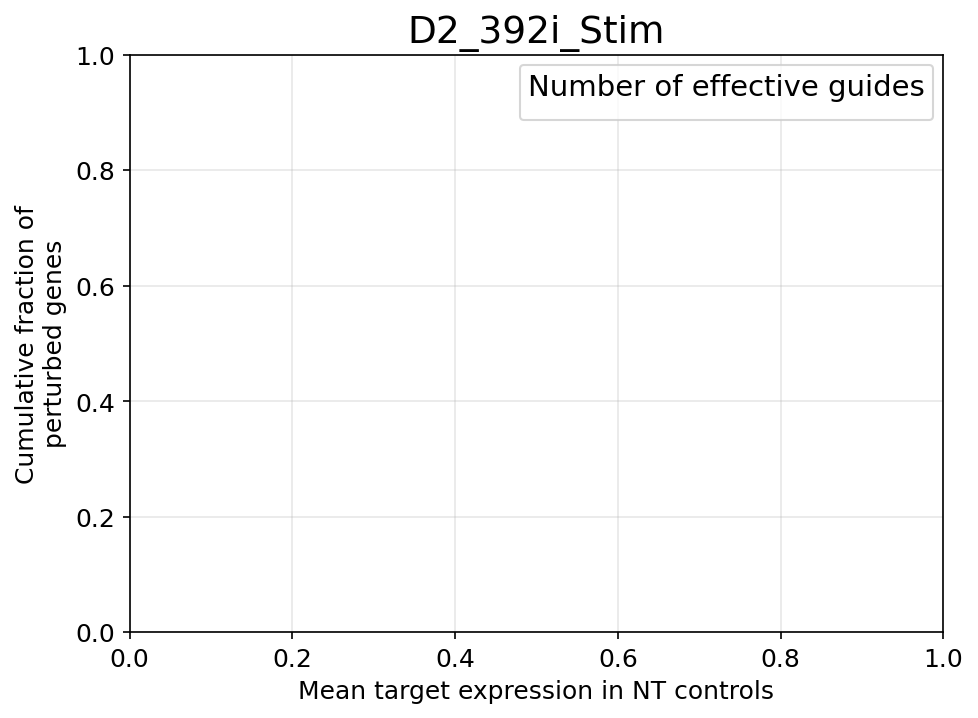

In [6]:
pth = '/Users/chandrima.modak/Gladstone Dropbox/Chandrima Modak/gw-CRISPRa_from_cluster/qc_stats'
exps = [i for i in os.listdir(pth)if i !='.DS_Store']
for exp in exps:
    csv_pattern = glob.glob(os.path.join(pth, exp, '*_guide_efficiency.csv'))[0]
    df = pd.read_csv(csv_pattern)
    pl_df = cummulative_fraction_pt(df, exp)
    plt_cummalative_pt(pl_df, exp)